In [1]:
# Cell 1: Imports & Kaggle Setup
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random

# Set style
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)


base_path = Path("/kaggle/input/spacenet-an-optimally-distributed-astronomy-data")

if (base_path / "train").exists():
    DATASET_PATH = base_path / "train"
elif (base_path / "spacenet_an_optimally_distributed_astronomy_data").exists():
    DATASET_PATH = base_path / "spacenet_an_optimally_distributed_astronomy_data" / "train"
else:

    DATASET_PATH = base_path

print(f"📂 Scanning directory: {DATASET_PATH}")
print(f"📂 Subfolders found: {[p.name for p in DATASET_PATH.iterdir() if p.is_dir()]}")

📂 Scanning directory: /kaggle/input/spacenet-an-optimally-distributed-astronomy-data
📂 Subfolders found: ['SpaceNet.FLARE.imam_alam']


In [7]:
import os
from pathlib import Path

root_dir = Path('/kaggle/input')

target_folder = None

print("  Scanning for the real dataset folder...")

for root, dirs, files in os.walk(root_dir):
    # Check if this folder contains the classes we expect
    if 'Galaxy' in dirs or 'galaxy' in dirs:
        print(f"  FOUND IT! The data is hiding here: {root}")
        target_folder = Path(root)
        break

if target_folder:
    # Set the global path to this correct folder
    DATASET_PATH = target_folder
else:
    print("  Could not auto-locate the class folders. Please check the directory structure manually.")

  Scanning for the real dataset folder...
  FOUND IT! The data is hiding here: /kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam


  Found 8 classes.


,Class,Count
0,asteroid,283
1,black hole,656
2,comet,416
3,constellation,1552
4,galaxy,3984
5,nebula,1192
6,planet,1472
7,star,3269


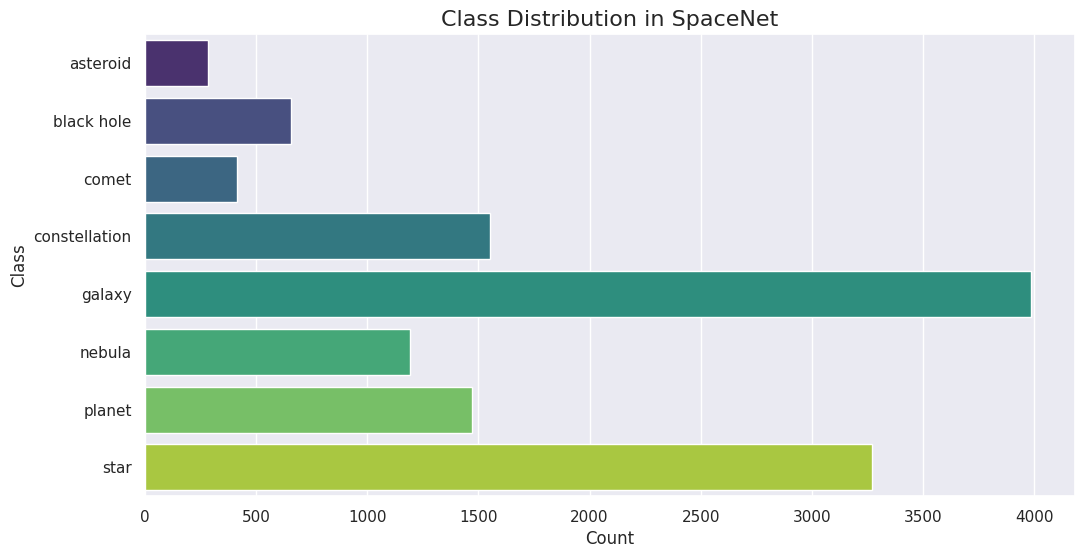

In [8]:
# Cell 2: Class Distribution
classes = [d.name for d in DATASET_PATH.iterdir() if d.is_dir()]
classes.sort()

class_counts = {}
for c in classes:
    # Count images in each folder
    count = len(list((DATASET_PATH / c).glob('*')))
    class_counts[c] = count

df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

print(f"  Found {len(classes)} classes.")
display(df_counts)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Class', data=df_counts, palette='viridis')
plt.title('Class Distribution in SpaceNet', fontsize=16)
plt.show()

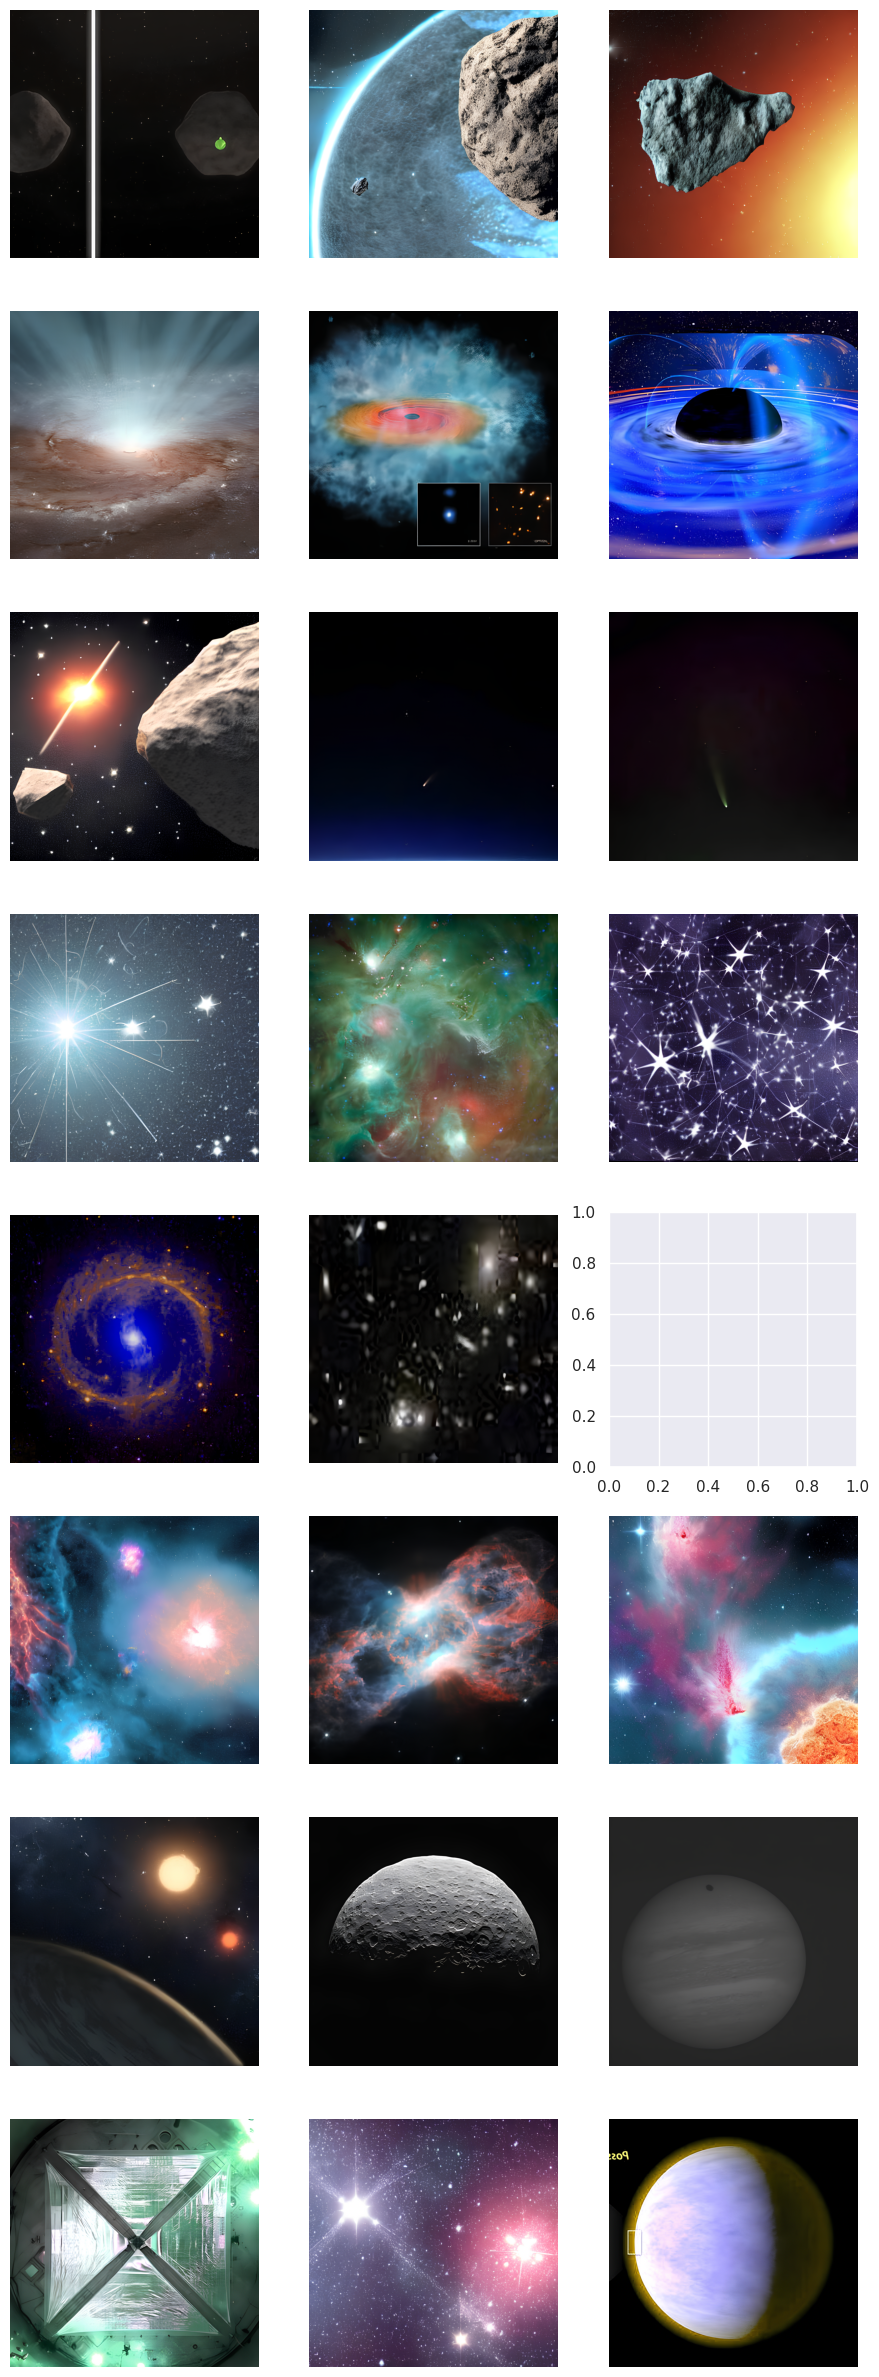

In [9]:
# Cell 3: Visualizing Samples
def show_samples(num_per_class=3):
    # Create a grid
    fig, axes = plt.subplots(len(classes), num_per_class, figsize=(num_per_class*3, len(classes)*3))
    
    for i, category in enumerate(classes):
        image_paths = list((DATASET_PATH / category).glob('*'))
        # Pick random images
        if len(image_paths) >= num_per_class:
            selected = random.sample(image_paths, num_per_class)
        else:
            selected = image_paths
        
        for j, img_path in enumerate(selected):
            img = cv2.imread(str(img_path))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Handle subplot indexing
                if len(classes) > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]
                
                ax.imshow(img)
                if j == 0:
                    ax.set_ylabel(category, fontsize=12, fontweight='bold')
                ax.axis('off')
            
    plt.tight_layout()
    plt.show()

show_samples()

   Analyzed 387 images:
   Avg Resolution: 2048x2048
   Formats found: {'.png'}


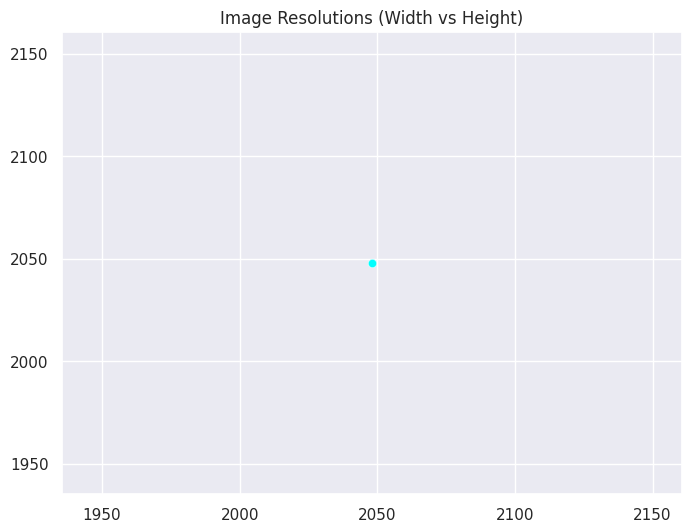

In [10]:
# Cell 4: Resolution Analysis
widths, heights, formats = [], [], []

# Check 50 random images from each class
for category in classes:
    files = list((DATASET_PATH / category).glob('*'))
    sample_files = random.sample(files, min(len(files), 50))
    
    for p in sample_files:
        img = cv2.imread(str(p))
        if img is not None:
            h, w, _ = img.shape
            widths.append(w)
            heights.append(h)
            formats.append(p.suffix)

print(f"   Analyzed {len(widths)} images:")
print(f"   Avg Resolution: {np.mean(widths):.0f}x{np.mean(heights):.0f}")
print(f"   Formats found: {set(formats)}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=widths, y=heights, alpha=0.5, color='cyan')
plt.title('Image Resolutions (Width vs Height)')
plt.show()

In [5]:
import os
import shutil
import random
from pathlib import Path

class DatasetOrganizer:
    """
    using Symlinks.
    """
    def __init__(self, source_path: str, destination_path: str, split_ratios: tuple = (0.8, 0.1, 0.1), seed: int = 42):
        self.source_path = Path(source_path)
        self.destination_path = Path(destination_path)
        self.train_ratio, self.test_ratio, self.eval_ratio = split_ratios
        self.seed = seed
        
        if abs(sum(split_ratios) - 1.0) > 1e-6:
            raise ValueError("Split ratios must sum to 1.0")

    def process(self):
        random.seed(self.seed)
        
        if not self.source_path.exists():
            raise FileNotFoundError(f"Source path '{self.source_path}' not found.")
            
        classes = [d.name for d in self.source_path.iterdir() if d.is_dir()]
        if not classes:
            print("No class directories found in source path.")
            return

        print(f"Found classes: {classes}")
        print(f"Splitting into: Train ({self.train_ratio}), Test ({self.test_ratio}), Eval ({self.eval_ratio})")

        # Create Destination Structure
        for split in ['train', 'test', 'eval']:
            for cls in classes:
                (self.destination_path / split / cls).mkdir(parents=True, exist_ok=True)

        for cls in classes:
            self._split_class(cls)
            
        print("\n✅ Dataset organization complete!")
        print(f"📂 New dataset location: {self.destination_path.resolve()}")

    def _split_class(self, class_name):
        class_dir = self.source_path / class_name
        files = [f for f in class_dir.iterdir() if f.is_file()]
        
        random.shuffle(files)
        
        n_total = len(files)
        n_train = int(n_total * self.train_ratio)
        n_test = int(n_total * self.test_ratio)
        
        train_files = files[:n_train]
        test_files = files[n_train:n_train + n_test]
        eval_files = files[n_train + n_test:]
        
        print(f"Processing '{class_name}': {len(train_files)} train, {len(test_files)} test, {len(eval_files)} eval")
        
        self._copy_files(train_files, 'train', class_name)
        self._copy_files(test_files, 'test', class_name)
        self._copy_files(eval_files, 'eval', class_name)

    def _copy_files(self, file_list, split_type, class_name):
        dest_dir = self.destination_path / split_type / class_name
        for src_file in file_list:
            # Using symlink instead of copy to save disk space
            link_path = dest_dir / src_file.name
            if not link_path.exists():
                os.symlink(src_file, link_path)

# --- EXECUTION SECTION ---
source_dataset_path = "/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam"
output_path = "./organized_dataset"

organizer = DatasetOrganizer(source_dataset_path, output_path)
organizer.process()

Found classes: ['planet', 'galaxy', 'black hole', 'asteroid', 'comet', 'star', 'constellation', 'nebula']
Splitting into: Train (0.8), Test (0.1), Eval (0.1)
Processing 'planet': 1177 train, 147 test, 148 eval
Processing 'galaxy': 3187 train, 398 test, 399 eval
Processing 'black hole': 524 train, 65 test, 67 eval
Processing 'asteroid': 226 train, 28 test, 29 eval
Processing 'comet': 332 train, 41 test, 43 eval
Processing 'star': 2615 train, 326 test, 328 eval
Processing 'constellation': 1241 train, 155 test, 156 eval
Processing 'nebula': 953 train, 119 test, 120 eval

✅ Dataset organization complete!
📂 New dataset location: /kaggle/working/organized_dataset


In [4]:
import shutil
import os

if os.path.exists("./organized_dataset"):
    shutil.rmtree("./organized_dataset")
    print("🧹 Cleaned up failed attempt.")

🧹 Cleaned up failed attempt.
